load optimization result of parameters retrieve

In [1]:
import sys
sys.path.append("..")

from Common.utils import *
import matplotlib.pyplot as plt
param = get_dyna_CMA() # much precise than original paper

In [2]:
import sympy
import numpy

import os
if not os.path.isfile('../Common/M_matrix.py'):
    rbt, panda_def = load_robot_model()
    # save Regressor as a py file
    M_matrix = sympybotics.robotcodegen.robot_code_to_func (
        'py' , rbt.M_code , 'M' , 'M_panda' , panda_def )
    C_matrix = sympybotics.robotcodegen.robot_code_to_func (
        'py' , rbt.C_code , 'C' , 'C_panda' , panda_def )
    G_vector = sympybotics.robotcodegen.robot_code_to_func (
        'py' , rbt.g_code , 'G' , 'G_panda' , panda_def )

    with open('../Common/M_matrix.py', 'w') as F:
        F.write(M_matrix)
    with open('../Common/C_matrix.py', 'w') as F:
        F.write(C_matrix)
    with open('../Common/G_vector.py', 'w') as F:
        F.write(G_vector)

In [3]:
from casadi import *
from Common.M_matrix import M_panda
from Common.C_matrix import C_panda
from Common.G_vector import G_panda

q_dq = casadi.SX.sym("q_dq", 14)
M = M_panda(param, q_dq[:7], cos, sin)
C = C_panda(param, q_dq[:7], q_dq[7:], cos, sin)
G = G_panda(param, q_dq[:7], cos, sin)

### The way to convert sympy to casadi expression, left here as backup

In [4]:
def sympy2casadi(sympy_expr,sympy_var,casadi_var):
    import casadi
    assert casadi_var.is_vector()
    if casadi_var.shape[1]>1:
        casadi_var = casadi_var.T
    casadi_var = casadi.vertsplit(casadi_var)
    from sympy.utilities.lambdify import lambdify

    mapping = {'ImmutableMatrix': casadi.blockcat,
             'MutableDenseMatrix': casadi.blockcat,
             'Abs':casadi.fabs
            }
    f = lambdify(sympy_var,sympy_expr,modules=[mapping, casadi])
    print(casadi_var)
    return f(*casadi_var)

### Start building the optimal control problem

In [5]:
M = vertcat(*M)
G = vertcat(*G)
C = vertcat(*C)

M = casadi.reshape(M, 7, 7)
G = casadi.reshape(G, 7, 1)
C = casadi.reshape(C, 7, 7)

In [6]:
G = casadi.simplify(G)
C = casadi.simplify(C)
M = casadi.simplify(M)

In [7]:
# 7 times faster than python function, C++ backend.
M_func = Function('M', [q_dq[:7]], [M])
C_func = Function('M', [q_dq], [C])
G_func = Function('M', [q_dq[:7]], [G])

#### G, C, M are symbolic function of q_dq

In [8]:
nx = 14  # state space \in R^14, first 7 dim are q, last 7 dim are qDot
na = 7
u = SX.sym('u', na)
dt = 0.001
q = q_dq[:7]
dq = q_dq[7:]
q_dq_dot_1 = dq
q_dq_dot_2 = casadi.inv(M) @ (u - C @ dq - G)

q_dq_dot = vertcat(q_dq_dot_1, q_dq_dot_2)

# dynamical system defined as a callable function
system = Function("sys", [q_dq, u], [q_dq_dot])

#### ode solver definition

In [9]:
ode = {'x': q_dq, 'ode': q_dq_dot, 'p': u}
opts = {'tf': dt}
ode_solver = integrator('F', 'idas', ode, opts)

### PD controller

sampling frequency is: 1000 Hz


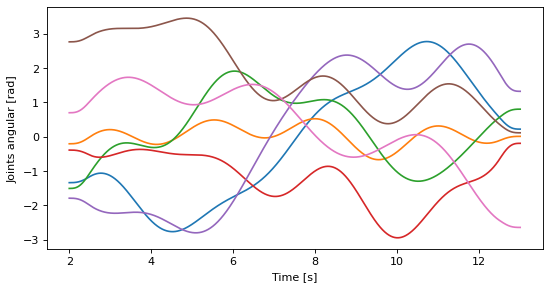

FileNotFoundError: [Errno 2] No such file or directory: '/home/jiayun/git/workspace/ArtificialDataGenerator/reference_traj/Trajectory_0/gen_q0.txt'

<Figure size 640x320 with 0 Axes>

In [19]:
from file import trans_format, Convert_q

ref_time, ref_q0, ref_dq, ref_ddq = trans_format(7)
ref_q = Convert_q('traj7', verbose=True)


# check if the traj span the whole state space
plt.figure(figsize=[8, 4], dpi=80)
for i in range(0,1):
    ref_time, ref_q0, ref_dq, ref_ddq = trans_format(i)
    ref_q = Convert_q('traj{}'.format(i), verbose=False)

In [122]:
Kp = np.array([700, 700, 700, 700, 500, 500, 500]).reshape(-1,1)
Kd = np.array([70, 70, 70, 70, 40, 40, 40]).reshape(-1,1)
# Ki = np.array([7, 7, 7, 7, 4, 4, 4]).reshape(-1,1)
# Define the total steps to simulate
N_sim = len(ref_time)

In [128]:
import matplotlib.pyplot as plt
from tqdm import tqdm
## add some noise to initial value
x_0 = np.concatenate([ref_q0.T, np.zeros([int(nx//2), 1])], axis=0)

# Define the input (for the moment consider u = 0)
u_k = np.zeros([7,1])

res_x_sundials = [x_0]
res_u = []

M_data = []
C_data = []
G_data = []

u_cmd_data = []
Ki_sum = np.zeros([7,1])
for i in tqdm(range(N_sim)):
    curr_q = x_0[:7]
    curr_dq = x_0[7:]
    error_q = curr_q - ref_q[i].reshape(7,1)
    error_dq = curr_dq - ref_dq[i].reshape(7,1)
    Ki_sum += error_q
    a_q = ref_ddq[i].reshape(7,1) - Kp*error_q - Kd*error_dq# - Ki*Ki_sum
    
    M_ = M_func(curr_q)
    C_ = C_func(np.concatenate([curr_q, curr_dq]))
    G_ = G_func(curr_q)
    C_ = C_@curr_dq
    u_cmd = M_@a_q + C_
    u_k = u_cmd + G_
    M_data.append(M_.full().flatten()[:,np.newaxis])
    C_data.append(C_)
    G_data.append(G_)
    u_cmd_data.append(a_q)
#     u_k = np.random.uniform(-20,20, (7,1))
    res_u.append(u_k)
    
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
    res_x_sundials.append(x_next)
    x_0 = x_next

100%|██████████| 11001/11001 [01:08<00:00, 161.68it/s]


In [129]:
res_x_sundials = np.concatenate(res_x_sundials, axis=1)
res_u = np.concatenate(res_u, axis=1)
M_data = np.concatenate(M_data, axis=1)
C_data = np.concatenate(C_data, axis=1)
G_data = np.concatenate(G_data, axis=1)
u_cmd_data = np.concatenate(u_cmd_data, axis=1)

In [132]:
with open('arti_traj_0.dat', 'w') as F:
     for line in zip(ref_time, res_x_sundials[:7,:].T, ref_q, res_x_sundials[7:,:].T,\
                         u_cmd_data.T, res_u.T, G_data.T, C_data.T, M_data.T, ref_dq):
            data_line = np.concatenate(line, axis=0)
            line_content = ' '.join(map(str, data_line))
            F.write(line_content + '\n')

- PD controller : 0.17301335653601874
- PID controller : 0.08687782771360693
- LQR finit: 0.056787246539001336

0.00550054095003446


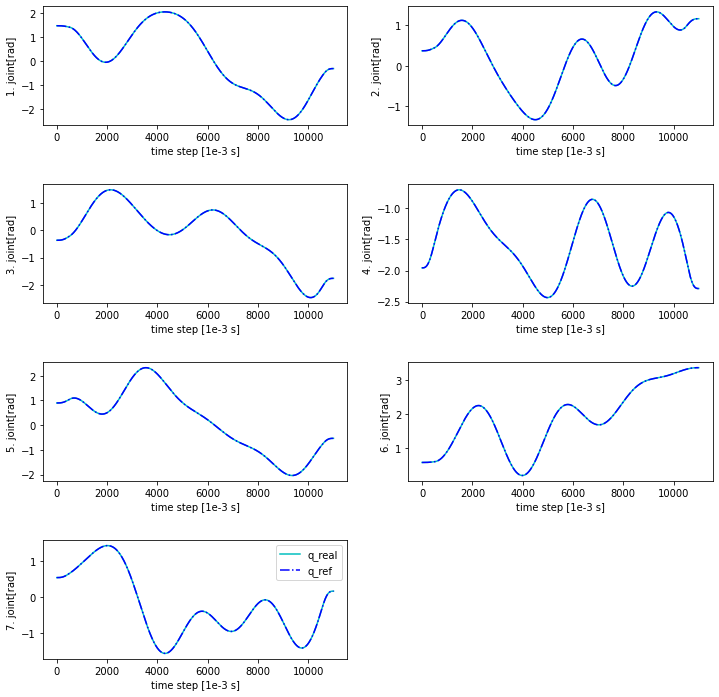

In [130]:
plt.figure(figsize=[12,12])
print(np.sum(np.abs(res_x_sundials[:7,1:]-ref_q.T))/(len(ref_q)) )
for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="time step [1e-3 s]", ylabel="{}. joint[rad]".format(channel+1))
    plt.plot(res_x_sundials[channel,:],'-c', label="q_real")
    plt.plot(ref_q[:,channel],'-.b', label="q_ref")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.legend()
plt.show()

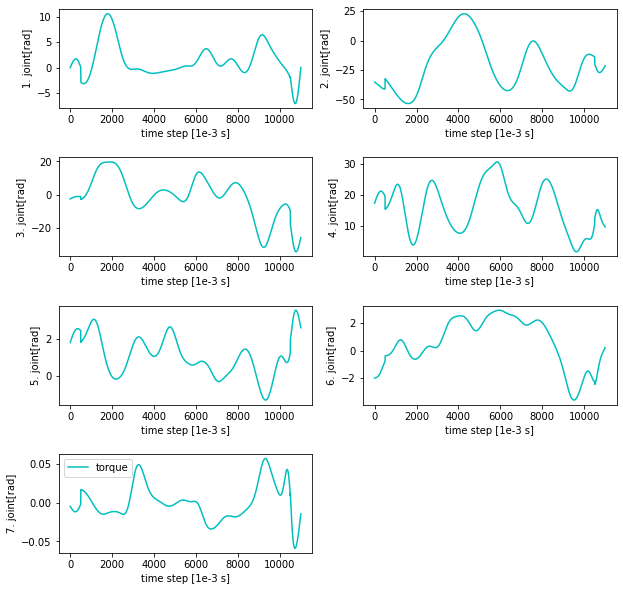

In [131]:
plt.figure(figsize=[10,10])

for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="time step [1e-3 s]", ylabel="{}. joint[rad]".format(channel+1))
    plt.plot(res_u[channel,:],'-c', label="torque")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.legend()
plt.show()

### Batch generation - 12 processing

In [22]:
#%%script false --no-raise-error
# magic prefix to skip this cell

# here the u_cmd is different from the definition by Professor Toussaint!!!
def artificial_data(whichone, hello):
    ref_time, ref_q0, ref_dq, ref_ddq = trans_format(whichone)
    ref_q = Convert_q('traj{}'.format(whichone), verbose=False)
    x_0 = np.concatenate([ref_q0.T, np.zeros([int(nx//2), 1])], axis=0) + np.random.randn(nx,1)*0.00001
    Kp = np.array([700, 700, 700, 700, 500, 500, 500]).reshape(-1,1)
    Kd = np.array([70, 70, 70, 70, 40, 40, 40]).reshape(-1,1)
    # Define the total steps to simulate
    N_sim = len(ref_time)
    
    import matplotlib.pyplot as plt
    from tqdm import tqdm

    # Define the input (for the moment consider u = 0)
    u_k = np.zeros([7,1])

    res_x_sundials = []
    res_u = [u_k]

    M_data = []
    C_data = []
    G_data = []

    u_cmd_data = []

    for i in tqdm(range(N_sim)):
        curr_q = x_0[:7]
        curr_dq = x_0[7:]
        error_q = curr_q - ref_q[i].reshape(7,1)
        error_dq = curr_dq - ref_dq[i].reshape(7,1)
        #print(Kp*error_q)
        a_q = ref_ddq[i].reshape(7,1) - Kp*error_q - Kd*error_dq

        M_ = M_func(curr_q)
        C_ = C_func(np.concatenate([curr_q, curr_dq]))
        G_ = G_func(curr_q)
        C_ = C_@curr_q
        u_cmd = a_q
        u_cmd_c_M = M_@a_q + C_
        u_k = u_cmd_c_M + G_
        M_data.append(M_.full().flatten()[:,np.newaxis])
        C_data.append(C_)
        G_data.append(G_)
        u_cmd_data.append(u_cmd)
        res_u.append(u_k)

        res_integrator = ode_solver(x0=x_0, p=u_k)
        x_next = res_integrator['xf']
        if i < N_sim-1:
            res_x_sundials.append(x_next)
        x_0 = x_next
        
    res_x_sundials = np.concatenate(res_x_sundials, axis=1)
    res_u = np.concatenate(res_u, axis=1)
    M_data = np.concatenate(M_data, axis=1)
    C_data = np.concatenate(C_data, axis=1)
    G_data = np.concatenate(G_data, axis=1)
    u_cmd_data = np.concatenate(u_cmd_data, axis=1)
    
    with open('arti_traj_{}.dat'.format(whichone), 'w') as F:
         for line in zip(ref_time, res_x_sundials[:7,:].T, ref_q, res_x_sundials[7:,:].T,\
                             u_cmd_data.T, res_u.T, G_data.T, C_data.T, M_data.T, ref_dq):
                data_line = np.concatenate(line, axis=0)
                line_content = ' '.join(map(str, data_line))
                F.write(line_content + '\n')


In [23]:
import multiprocessing
whichOneList = np.arange(0,100)
IterNumber = 100 // 10
for i in range(IterNumber):
    whichOneListProcess = whichOneList[i*10:(i+1)*10]
    print("Hello!")
    print(whichOneListProcess)
    for Pi in range(10):
        exec('P{0} = multiprocessing.Process(target=artificial_data, args=(whichOneListProcess[{0}], "Hello"))'.format(Pi))
    for i in range(10):
        exec('P{}.start()'.format(i))
    for i in range(10):
        exec('P{}.join()'.format(i))

    print('Sampling traj ... ')

Hello!
[0 1 2 3 4 5 6 7 8 9]


100%|██████████| 11001/11001 [01:55<00:00, 95.58it/s]


Sampling traj ... 
Hello!
[10 11 12 13 14 15 16 17 18 19]


100%|██████████| 11001/11001 [01:52<00:00, 98.00it/s]


Sampling traj ... 
Hello!
[20 21 22 23 24 25 26 27 28 29]


100%|██████████| 11001/11001 [01:52<00:00, 97.92it/s]


Sampling traj ... 
Hello!
[30 31 32 33 34 35 36 37 38 39]


100%|██████████| 11001/11001 [01:52<00:00, 97.50it/s] 


Sampling traj ... 
Hello!
[40 41 42 43 44 45 46 47 48 49]


100%|██████████| 11001/11001 [01:51<00:00, 98.68it/s]


Sampling traj ... 
Hello!
[50 51 52 53 54 55 56 57 58 59]


100%|██████████| 11001/11001 [01:53<00:00, 97.06it/s] 


Sampling traj ... 
Hello!
[60 61 62 63 64 65 66 67 68 69]


100%|██████████| 11001/11001 [01:52<00:00, 97.45it/s]


Sampling traj ... 
Hello!
[70 71 72 73 74 75 76 77 78 79]


100%|██████████| 11001/11001 [01:54<00:00, 96.15it/s] 


Sampling traj ... 
Hello!
[80 81 82 83 84 85 86 87 88 89]


100%|██████████| 11001/11001 [01:54<00:00, 96.16it/s] 


Sampling traj ... 
Hello!
[90 91 92 93 94 95 96 97 98 99]


100%|██████████| 11001/11001 [01:51<00:00, 98.95it/s]


Sampling traj ... 
